# **Toxic Comment Classification**
**Dataset:**[Jigsaw Toxic Comment Classification Challenge Kaggle Competition](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)<br>
   **Requirements:**
   - Bag-of-Words (BOW) model
   - LSTM, GRU models

## **Imports**

 **Install required packages**

In [ ]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 14.4 MB/s eta 0:00:00


In [ ]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 4.7 MB/s eta 0:00:00


In [ ]:
!pip install kaggle

**Import necessary libraries**

In [ ]:
import string
import re
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

import spacy
import contractions
import emoji

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

import gensim
from gensim.models import word2vec, KeyedVectors

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, GlobalMaxPooling1D, LSTM, Bidirectional, SimpleRNN, Dense, Dropout, SpatialDropout1D, GRU
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras import regularizers
from keras.regularizers import l2


**Set Pandas display options**

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)

**Download NLTK resources**

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Downloading the data

**Create directory for storing Kaggle API key**<br>
**Copy Kaggle API key to the appropriate directory**

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

**Set appropriate permissions for the Kaggle API key file**

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

**Download dataset from Kaggle competition**

In [ ]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

 78% 41.0M/52.6M [00:00<00:00, 218MB/s]
100% 52.6M/52.6M [00:00<00:00, 227MB/s]


**Unzip the downloaded files**

In [ ]:
!unzip /content/jigsaw-toxic-comment-classification-challenge.zip

Archive:  /content/jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           


**Unzip the individual files within the downloaded zip files**

In [ ]:
!unzip /content/sample_submission.csv.zip
!unzip /content/test.csv.zip
!unzip /content/test_labels.csv.zip
!unzip /content/train.csv.zip

Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/test_labels.csv.zip
  inflating: test_labels.csv         
Archive:  /content/train.csv.zip
  inflating: train.csv               


**Read the datasets into Pandas DataFrames**

In [ ]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sample = pd.read_csv('./sample_submission.csv')
test_labels = pd.read_csv('./test_labels.csv')

## Data Exploration

In [ ]:
# Display the first few rows of the training dataset
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess t...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [ ]:
# Display the first comment from the 'comment_text' column in the training dataset
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
# Display the first few rows of the test dataset
test.head()

,id,comment_text
0,00001cee341fdb12,"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"
1,0000247867823ef7,"== From RfC == \n\n The title is fine as it is, IMO."
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lapland — / """
3,00017563c3f7919a,":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
# Display the first few rows of the test labels dataset
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


**Plot a histogram of comment lengths**

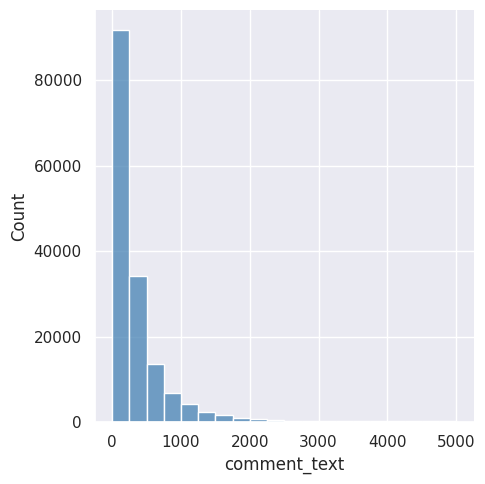

In [ ]:
sns.set(color_codes=True)

# Calculate the length of each comment in the 'comment_text' column
comment_len = train.comment_text.str.len()

# Create a histogram of comment lengths
sns.displot(comment_len, kde=False, bins=20, color="steelblue")

**Plot the distribution of text lengths for the dataset**

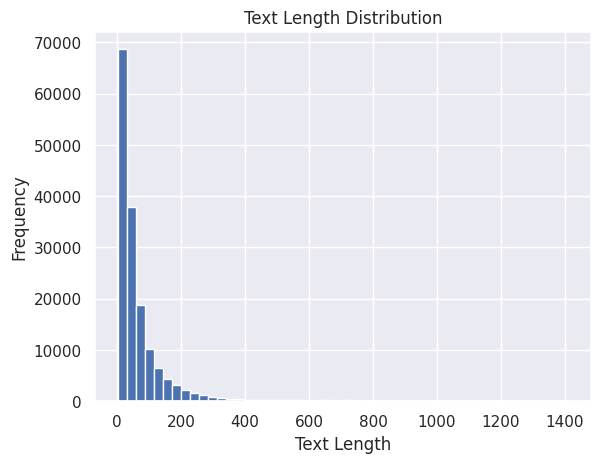

In [ ]:
def plot_text_length_distribution(texts):
    """
    Plot the distribution of text lengths.

    Args:
    texts (list): A list of text strings.

    Returns:
    None
    """
    # Calculate the length of each text (number of words)
    text_lengths = [len(text.split()) for text in texts]

    # Plot a histogram of text lengths with 50 bins
    plt.hist(text_lengths, bins=50)

    # Set labels and title
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.title('Text Length Distribution')

    # Display the plot
    plt.show()

plot_text_length_distribution(train['comment_text'])

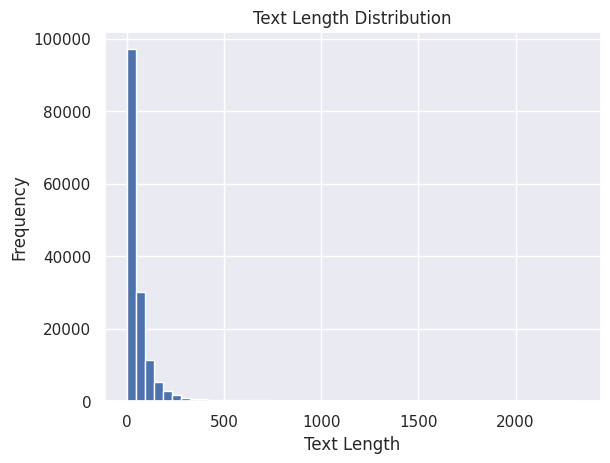

In [ ]:
plot_text_length_distribution(test['comment_text'])

In [ ]:
target_columns = list(sample.columns.drop('id'))
target_columns

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
labels_count = train[target_columns].sum()
labels_count

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

**Plot a bar chart of label frequencies**

<Axes: title={'center': 'Labels Frequency'}>

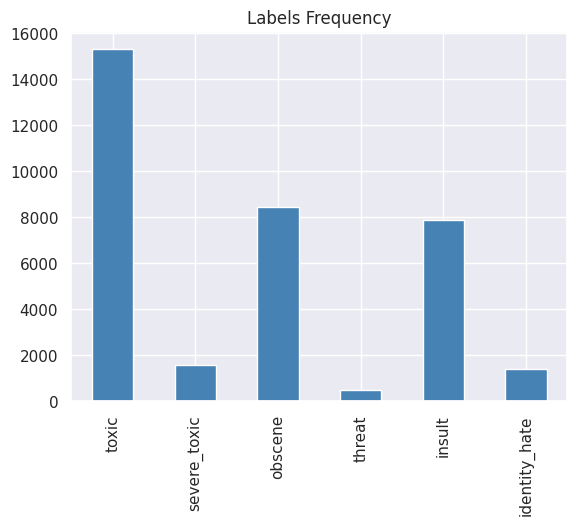

In [ ]:
labels_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

In [ ]:
#Replace -1 values in test labels with 0
test_labels[target_columns] = test_labels[target_columns].replace(-1, 0)

**Drop unnecessary columns**

In [ ]:
columns_to_drop = ['id', 'comment_text']
new_columns = [col for col in train.columns if col not in columns_to_drop]
new_columns

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
new_labels_count = train[new_columns].sum()
new_labels_count

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

**Plot a bar chart of label frequencies in the modified training dataset**

In [ ]:
train_labels = train.drop(columns=['comment_text', 'id'])

**Plot a correlation heatmap of target columns**

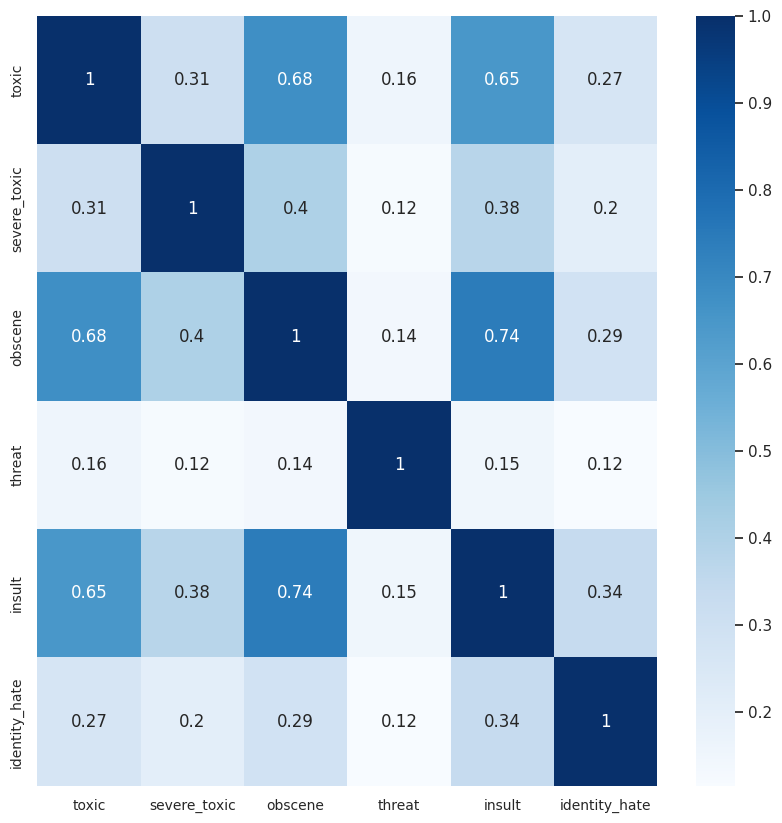

In [ ]:
heatmap_data = train[target_columns]
plt.figure(figsize=(10, 10))
ax = sns.heatmap(heatmap_data.corr(), cmap='Blues', annot=True)
ax.tick_params(labelsize=10)

**We can deduce that insult, toxic and obscene comments are highly collerated**

## Data Preprocessing

**Define a function to clean text data**

In [ ]:
def clean_text(text):
    """
    Clean text data by performing various preprocessing steps.

    Args:
    text (str): Input text to be cleaned.

    Returns:
    str: Cleaned text.
    """
    # Remove special characters, symbols, and digits
    cleaned_text = re.sub(r'[^a-zA-Z\d\s]', '', text)
    # Remove digits
    cleaned_text = re.sub(r'\d+', '', cleaned_text)
    # Replace newline and tab characters with space
    cleaned_text = cleaned_text.replace('\n', ' ').replace('\t', ' ')
    # Remove URLs
    cleaned_text = re.sub(r'https?:\/\/.*[\r\n]*', '', cleaned_text)
    # Fix contractions
    cleaned_text = contractions.fix(cleaned_text)
    # Remove punctuation
    cleaned_text = cleaned_text.translate(str.maketrans('', '', string.punctuation))
    # Convert emojis to text
    cleaned_text = emoji.demojize(cleaned_text)
    # Remove ":" from emojis
    cleaned_text = cleaned_text.replace(":", "")
    # Convert text to lowercase
    cleaned_text = cleaned_text.lower()
    # Remove leading and trailing whitespaces
    cleaned_text = cleaned_text.strip()

    return cleaned_text


**Initialize WordNet Lemmatizer**

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def lemmatize_tokens(text):
    """
    Lemmatize tokens in the input text using WordNet Lemmatizer.

    Args:
    text (str): Input text to be lemmatized.

    Returns:
    str: Lemmatized text.
    """
    # Lemmatize each token in the input text if it's not in the stop words list
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])

    return lemmatized_text

**Define a function to stem tokens in text**

In [ ]:
stemmer = PorterStemmer()

def stem_tokens(text):
    """
    Stem tokens in the input text using Porter Stemmer.

    Args:
    text (str): Input text to be stemmed.

    Returns:
    str: Stemmed text.
    """
    # Split the input text into tokens and stem each token
    stemmed_text = ' '.join([stemmer.stem(word) for word in text.split()])

    return stemmed_text

In [ ]:
train['comment_text']

0                                                                                                                                                                                                                                                   Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
1                                                                                                                                                                                                                                                                                                                                                                                                            D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, Jan

**Apply cleaning and lemmatization functions to the 'comment_text' column**

In [ ]:
train['clean_text'] = train['comment_text'].apply(clean_text)

In [ ]:
train['clean_text']

0                                                                                                                                                                                                                                                                 explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now
1                                                                                                                                                                                                                                                                                                                                                                                                                                daww he matches this background colour i am seemingly stuck with thanks  

In [ ]:
train['clean_text'] = train['clean_text'].apply(lemmatize_tokens)

In [ ]:
train['clean_text']

0                                                                                                                                                                                                                               explanation edits made username hardcore metallica fan reverted vandalism closure gas voted new york doll fac please remove template talk page since retired
1                                                                                                                                                                                                                                                                                                                       daww match background colour seemingly stuck thanks talk january utc
2                                                                                                                                                                                                                                             

In [ ]:
test['clean_text'] = test['comment_text'].apply(clean_text)

In [ ]:
test['clean_text'] = test['clean_text'].apply(lemmatize_tokens)

In [ ]:
test

,id,comment_text,clean_text
0,00001cee341fdb12,"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,",yo bitch ja rule succesful ever hating sad mofuckasi bitch slap pethedic white face get kiss as guy sicken ja rule pride da music man dis shit nothin wrong bein like tupac brother toofuckin white boy get thing right next time
1,0000247867823ef7,"== From RfC == \n\n The title is fine as it is, IMO.",rfc title fine going
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lapland — / """,source zawe ashton lapland
3,00017563c3f7919a,":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message.",look back source information updated correct form guess source updated shall update information thank message
4,00017695ad8997eb,I don't anonymously edit articles at all.,anonymously edit article
...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing but too-long-crap",totally agree stuff nothing toolongcrap
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n Does it get there faster by throwing to cut off man or direct from out fielder? \n Were the out fielders in the Mickey mantle era have better arms? \n Rich,throw field home plate get faster throwing cut man direct fielder fielder mickey mantle era better arm rich
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I see your changes and agree this is """"more correct."""" I had gotten confused, but then found this: \n :... while acknowledging Japan's territorial rights to Okinotorishima itself ... \n However, is there a category for \n :... did not acknowledge Japan's claim to an exclusive economic zone (EEZ) stemming from Okinotorishima. \n That is, is there a category for """"disputed EEZ""""s? """,okinotorishima category see change agree correct gotten confused found acknowledging japan territorial right okinotorishima however category acknowledge japan claim exclusive economic zone eez stemming okinotorishima category disputed eezs
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the EU - Germany - has a Law of Return quite similar to Israel's"""" == \n\n This isn't actually true, is it? Germany allows people whose ancestors were citizens of Germany to return, but AFAIK it does not allow the descendants of Anglo-Saxons to """"return"""" to Angeln and Saxony. Israel, by contrast, allows all Jews to """"return"""" to Israel, even if they can't trace a particular ancestral line to anyone who lived in the modern state or even mandate Pale...",one founding nation eu germany law return quite similar israel actually true germany allows people whose ancestor citizen germany return afaik allow descendant anglosaxons return angeln saxony israel contrast allows jew return israel even cannot trace particular ancestral line anyone lived modern state even mandate palestine


In [ ]:
test_labels.drop(columns=['id'], inplace=True)

In [ ]:
test_labels

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
153159,0,0,0,0,0,0
153160,0,0,0,0,0,0
153161,0,0,0,0,0,0
153162,0,0,0,0,0,0


## BOW


**A Bag of Words (BoW) is a way to represent text data as numerical vectors, where each vector element corresponds to the count of a word in a fixed vocabulary within a document. It simplifies text by ignoring word order and focuses on word frequency.**

In [ ]:
max_length = 100  # Maximum length of a sequence
embedding_dim = 128  # Dimensionality of the embedding
num_classes = 6  # Number of classes (assuming multi-label classification)

In [ ]:
BOW_tokenizer = Tokenizer()
BOW_tokenizer.fit_on_texts(train['clean_text'])
word_index = BOW_tokenizer.word_index

In [ ]:
# Convert text to sequences and pad them
BOW_train_sequences = BOW_tokenizer.texts_to_sequences(train['clean_text'])
BOW_train_padded = pad_sequences(BOW_train_sequences, maxlen=max_length)

BOW_test_sequences = BOW_tokenizer.texts_to_sequences(test['clean_text'])
BOW_test_padded = pad_sequences(BOW_test_sequences, maxlen=max_length)

**Model Architecture**:<br>
- Add an embedding layer with input dimensions (vocabulary size + 1) and output dimensions (embedding_dim) , Input length is set to max_length, which is the maximum length of input sequences
- Flatten the 3D embedding output to 2D
- Add a dense layer with 256 units and ReLU activation function , Regularization is applied using L2 regularization with a regularization parameter of 0.01
- Apply dropout regularization with a rate of 0.2 to prevent overfitting
- Add another dense layer with 128 units and ReLU activation function , Regularization is applied using L2 regularization with a regularization parameter of 0.01
- Add the output layer with num_classes units and sigmoid activation function, Sigmoid activation is used for multi-label classification tasks


In [ ]:
# Define the model
bow_model = Sequential()
bow_model.add(Embedding(len(word_index) + 1, embedding_dim, input_length=max_length))
bow_model.add(Flatten())
bow_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
bow_model.add(Dropout(0.2))
bow_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
bow_model.add(Dropout(0.2))
bow_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
bow_model.add(Dense(num_classes, activation='sigmoid'))

In [ ]:
# Compile the model with binary cross-entropy loss
bow_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [ ]:
# Train the model
bow_history = bow_model.fit(BOW_train_padded, train_labels, epochs=20, batch_size=512, validation_split=0.2)

Epoch 1/20
250/250 [==============================] - 30s 95ms/step - loss: 0.9043 - binary_accuracy: 0.9595 - val_loss: 0.1238 - val_binary_accuracy: 0.9655
Epoch 2/20
250/250 [==============================] - 19s 75ms/step - loss: 0.1089 - binary_accuracy: 0.9727 - val_loss: 0.0996 - val_binary_accuracy: 0.9777
Epoch 3/20
250/250 [==============================] - 13s 52ms/step - loss: 0.0912 - binary_accuracy: 0.9787 - val_loss: 0.0946 - val_binary_accuracy: 0.9784
Epoch 4/20
250/250 [==============================] - 10s 41ms/step - loss: 0.0834 - binary_accuracy: 0.9803 - val_loss: 0.0874 - val_binary_accuracy: 0.9784
Epoch 5/20
250/250 [==============================] - 9s 37ms/step - loss: 0.0782 - binary_accuracy: 0.9812 - val_loss: 0.0850 - val_binary_accuracy: 0.9786
Epoch 6/20
250/250 [==============================] - 8s 34ms/step - loss: 0.0749 - binary_accuracy: 0.9819 - val_loss: 0.0834 - val_binary_accuracy: 0.9794
Epoch 7/20
250/250 [==============================] - 

In [ ]:
# Evaluate the model on test data
BOW_loss,BOW_accuracy = bow_model.evaluate(BOW_test_padded, test_labels)
print("Test Accuracy:", BOW_accuracy)

4787/4787 [==============================] - 12s 3ms/step - loss: 0.1773 - binary_accuracy: 0.9455
Test Accuracy: 0.9454660415649414


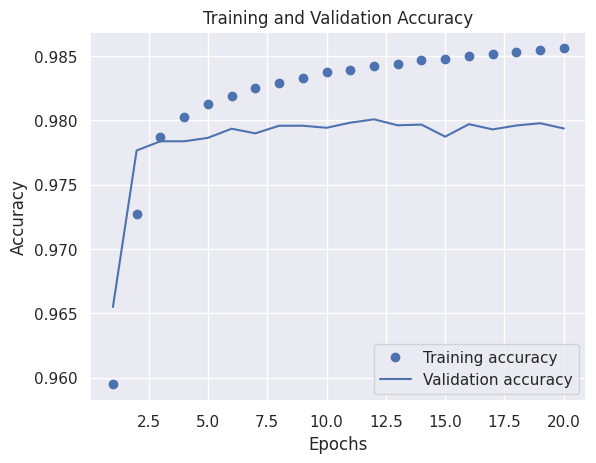

In [ ]:
training_accuracy = bow_history.history['binary_accuracy']
validation_accuracy = bow_history.history['val_binary_accuracy']
epochs = range(1, len(training_accuracy) + 1)

plt.plot(epochs, training_accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
predictions = bow_model.predict(BOW_test_padded)

4787/4787 [==============================] - 9s 2ms/step


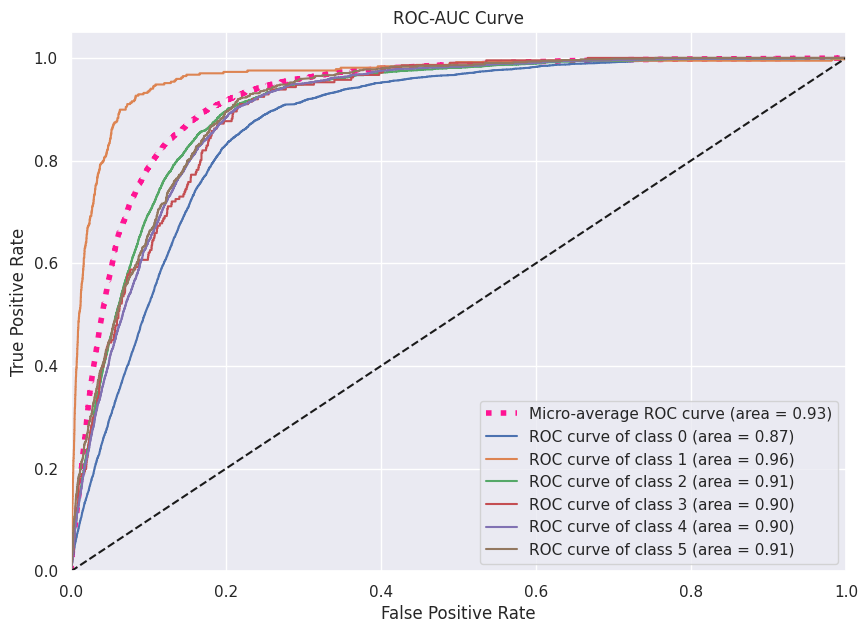

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Convert predictions to binary predictions
threshold = 0.5  # Adjust this threshold based on your problem
binary_predictions = (predictions > threshold).astype(int)

# Convert test_labels to numpy array if it's not already
test_labels_np = np.array(test_labels)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_np[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(test_labels_np.ravel(), predictions.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr_micro, tpr_micro, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_micro), color='deeppink', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
def preprocess_text(sentence):
    """
    Preprocesses a single sentence by cleaning, stemming, lemmatizing, tokenizing, and padding it.

    Parameters:
    sentence (str): The input sentence to be preprocessed.

    Returns:
    numpy.ndarray: The preprocessed and padded sequence.
    """
    # Clean the input sentence
    cleaned_sent = clean_text(sentence)

    # Stem the cleaned sentence
    stemmed_sent = stem_tokens(cleaned_sent)

    # Lemmatize the stemmed sentence
    lemmatized_sent = lemmatize_tokens(stemmed_sent)

    # Convert the lemmatized sentence to a sequence of integers
    sequence = BOW_tokenizer.texts_to_sequences([lemmatized_sent])

    # Pad the sequence to ensure uniform length
    padded_sequence = pad_sequences(sequence, maxlen=max_length)

    return padded_sequence


In [ ]:
def classify_toxicity(sentence, model, tokenizer, max_length, threshold=0.5):
    """
    Classifies the toxicity of a given sentence using a trained model.

    Parameters:
    sentence (str): The input sentence to be classified.
    model (keras.Model): The trained model for toxicity classification.
    tokenizer (keras.preprocessing.text.Tokenizer): The Tokenizer object used for tokenization.
    max_length (int): The maximum length of sequences after padding.
    threshold (float): The threshold value for binary classification (default is 0.5).

    Returns:
    int: 1 if the sentence is classified as toxic, 0 if it is classified as non-toxic.
    """
    # Preprocess the sentence
    cleaned_sentence = preprocess_text(sentence)

    # Tokenize and pad the preprocessed sentence
    sequence = BOW_tokenizer.texts_to_sequences([cleaned_sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_length)

    # Apply threshold for binary classification
    prediction = model.predict(np.array([padded_sequence])) > threshold

    return prediction  # Return 1 if toxic, 0 if non-toxic


In [ ]:
comment_toxic = 'i hate you, kill yourself'
preprocessed_toxic_comment = preprocess_text(comment_toxic)
probabilities = bow_model.predict(preprocessed_toxic_comment)

threshold = 0.5
binary_prediction = (probabilities > threshold).astype(int)
prediction_text = ""
for i, col in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    prediction_text += f"{col:<{20}}: {binary_prediction[0][i]:<{5}}\n"
print(prediction_text)

1/1 [==============================] - 0s 60ms/step
toxic               : 1    
severe_toxic        : 0    
obscene             : 0    
threat              : 0    
insult              : 0    
identity_hate       : 0    



In [ ]:
comment_non = "you're amazing"
preprocessed_non_comment = preprocess_text(comment_non)
probabilities = bow_model.predict(preprocessed_non_comment)


threshold = 0.5
binary_prediction = (probabilities > threshold).astype(int)
prediction_text = ""
for i, col in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    prediction_text += f"{col:<{20}}: {binary_prediction[0][i]:<{5}}\n"
print(prediction_text)

1/1 [==============================] - 0s 42ms/step
toxic               : 0    
severe_toxic        : 0    
obscene             : 0    
threat              : 0    
insult              : 0    
identity_hate       : 0    



**Conclusion of BoW**<br>

The Bag-of-Words (BoW) model achieved a test accuracy of 94%.<br> The ROC-AUC curves and scores for each class provide further insight into the model's performance across different classes.<br> Analyzing these metrics can help in identifying potential areas for improvement and further tuning the model.

## LSTM

In [ ]:
# Tokenize the text
LSTM_tokenizer = Tokenizer()
# Fit the Tokenizer on the cleaned text data from the train DataFrame
LSTM_tokenizer.fit_on_texts(train['clean_text'])
# Create a dictionary mapping words to their indices based on the Tokenizer's vocabulary
word_index = LSTM_tokenizer.word_index

In [ ]:
# Convert text to sequences and pad them
LSTM_train_sequences = LSTM_tokenizer.texts_to_sequences(train['clean_text'])
LSTM_train_padded = pad_sequences(LSTM_train_sequences, maxlen=max_length)

LSTM_test_sequences = LSTM_tokenizer.texts_to_sequences(test['clean_text'])
LSTM_test_padded = pad_sequences(LSTM_test_sequences, maxlen=max_length)

In [ ]:
# Define the model
lstm_model = Sequential()
lstm_model.add(Embedding(len(word_index) + 1, embedding_dim, input_length=max_length))
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=regularizers.l2(0.001)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(num_classes, activation='sigmoid'))

In [ ]:
# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [ ]:
# Train the model
lstm_history = lstm_model.fit(LSTM_train_padded, train_labels, epochs=20, batch_size=512, validation_split=0.2)

Epoch 1/20
250/250 [==============================] - 116s 447ms/step - loss: 0.1911 - binary_accuracy: 0.9605 - val_loss: 0.1389 - val_binary_accuracy: 0.9635
Epoch 2/20
250/250 [==============================] - 109s 437ms/step - loss: 0.1038 - binary_accuracy: 0.9694 - val_loss: 0.0748 - val_binary_accuracy: 0.9766
Epoch 3/20
250/250 [==============================] - 97s 389ms/step - loss: 0.0642 - binary_accuracy: 0.9791 - val_loss: 0.0609 - val_binary_accuracy: 0.9796
Epoch 4/20
250/250 [==============================] - 92s 370ms/step - loss: 0.0603 - binary_accuracy: 0.9788 - val_loss: 0.0593 - val_binary_accuracy: 0.9803
Epoch 5/20
250/250 [==============================] - 93s 373ms/step - loss: 0.0506 - binary_accuracy: 0.9827 - val_loss: 0.0623 - val_binary_accuracy: 0.9802
Epoch 6/20
250/250 [==============================] - 90s 361ms/step - loss: 0.0474 - binary_accuracy: 0.9838 - val_loss: 0.0615 - val_binary_accuracy: 0.9803
Epoch 7/20
250/250 [========================

In [ ]:
LSTM_loss, LSTM_accuracy = lstm_model.evaluate(LSTM_test_padded, test_labels)
print("Test Accuracy:", LSTM_accuracy)

4787/4787 [==============================] - 159s 33ms/step - loss: 0.2429 - binary_accuracy: 0.9250
Test Accuracy: 0.9250417351722717


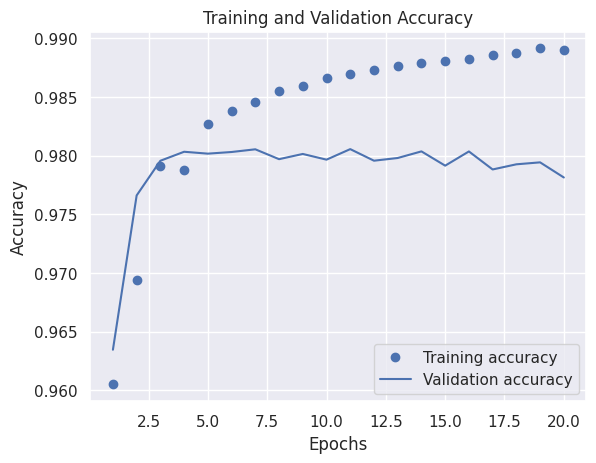

In [ ]:
import matplotlib.pyplot as plt

# Get training history
training_accuracy = lstm_history.history['binary_accuracy']
validation_accuracy = lstm_history.history['val_binary_accuracy']
epochs = range(1, len(training_accuracy) + 1)

plt.plot(epochs, training_accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
predictions = lstm_model.predict(LSTM_test_padded)

4787/4787 [==============================] - 148s 31ms/step


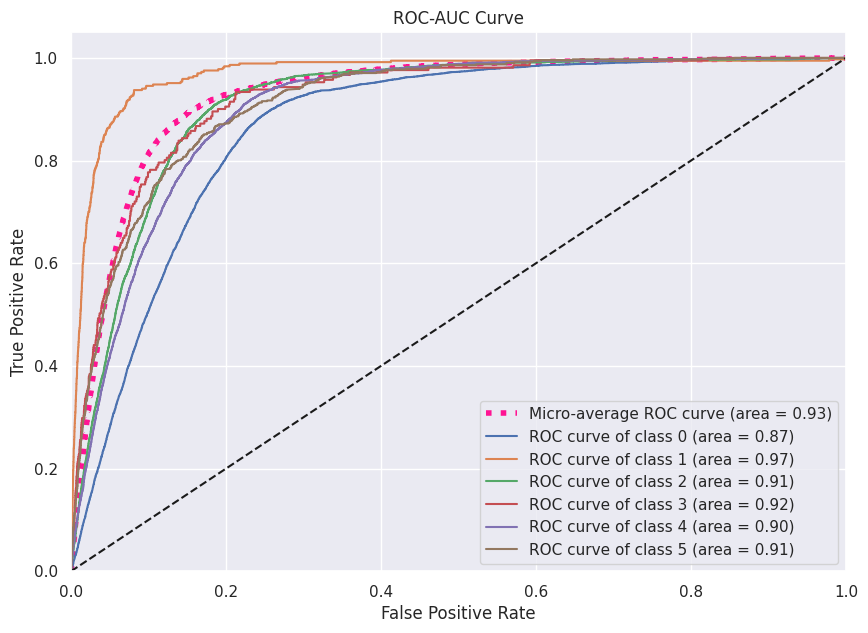

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Convert predictions to binary predictions
threshold = 0.5  # Adjust this threshold based on your problem
binary_predictions = (predictions > threshold).astype(int)

# Convert test_labels to numpy array if it's not already
test_labels_np = np.array(test_labels)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_np[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(test_labels_np.ravel(), predictions.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr_micro, tpr_micro, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_micro), color='deeppink', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
def preprocess_text(sentence):
    """
    Preprocesses a single sentence by cleaning, stemming, lemmatizing, tokenizing, and padding it.

    Parameters:
    sentence (str): The input sentence to be preprocessed.

    Returns:
    numpy.ndarray: The preprocessed and padded sequence.
    """
    # Clean the input sentence
    cleaned_sent = clean_text(sentence)

    # Stem the cleaned sentence
    stemmed_sent = stem_tokens(cleaned_sent)

    # Lemmatize the stemmed sentence
    lemmatized_sent = lemmatize_tokens(stemmed_sent)

    # Convert the lemmatized sentence to a sequence of integers
    sequence = LSTM_tokenizer.texts_to_sequences([lemmatized_sent])

    # Pad the sequence to ensure uniform length
    padded_sequence = pad_sequences(sequence, maxlen=max_length)

    return padded_sequence


In [ ]:
def classify_toxicity(sentence, model, tokenizer, max_length, threshold=0.5):
    """
    Classifies the toxicity of a given sentence using a trained model.

    Parameters:
    sentence (str): The input sentence to be classified.
    model (keras.Model): The trained model for toxicity classification.
    tokenizer (keras.preprocessing.text.Tokenizer): The Tokenizer object used for tokenization.
    max_length (int): The maximum length of sequences after padding.
    threshold (float): The threshold value for binary classification (default is 0.5).

    Returns:
    int: 1 if the sentence is classified as toxic, 0 if it is classified as non-toxic.
    """
    # Preprocess the sentence
    cleaned_sentence = preprocess_text(sentence)

    # Tokenize and pad the preprocessed sentence
    sequence = LSTM_tokenizer.texts_to_sequences([cleaned_sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_length)

    # Apply threshold for binary classification
    prediction = model.predict(np.array([padded_sequence])) > threshold

    return prediction  # Return 1 if toxic, 0 if non-toxic


In [ ]:
comment_toxic = 'i hate you, kill yourself, screw you'
preprocessed_toxic_comment = preprocess_text(comment_toxic)
probabilities = lstm_model.predict(preprocessed_toxic_comment)

threshold = 0.5
binary_prediction = (probabilities > threshold).astype(int)
prediction_text = ""
for i, col in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    prediction_text += f"{col:<{20}}: {binary_prediction[0][i]:<{5}}\n"
print(prediction_text)

1/1 [==============================] - 0s 42ms/step
toxic               : 1    
severe_toxic        : 0    
obscene             : 1    
threat              : 0    
insult              : 1    
identity_hate       : 0    



In [ ]:
comment_non = "you're amazing"
preprocessed_non_comment = preprocess_text(comment_non)
probabilities = lstm_model.predict(preprocessed_non_comment)


threshold = 0.5
binary_prediction = (probabilities > threshold).astype(int)
prediction_text = ""
for i, col in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    prediction_text += f"{col:<{20}}: {binary_prediction[0][i]:<{5}}\n"
print(prediction_text)

1/1 [==============================] - 0s 66ms/step
toxic               : 0    
severe_toxic        : 0    
obscene             : 0    
threat              : 0    
insult              : 0    
identity_hate       : 0    



**Conclusion of LSTM**

The LSTM model achieved a test accuracy of 92%.
The ROC-AUC curves and scores for each class provide further insight into the model's performance across different classes.
Analyzing these metrics can help in identifying potential areas for improvement and further tuning the model.



## GRU

In [ ]:
# Tokenize the text
GRU_tokenizer = Tokenizer()
GRU_tokenizer.fit_on_texts(train['clean_text'])
word_index = GRU_tokenizer.word_index

# Convert text to sequences and pad them
GRU_train_sequences = GRU_tokenizer.texts_to_sequences(train['clean_text'])
GRU_train_padded = pad_sequences(GRU_train_sequences, maxlen=max_length)

GRU_test_sequences = GRU_tokenizer.texts_to_sequences(test['clean_text'])
GRU_test_padded = pad_sequences(GRU_test_sequences, maxlen=max_length)

# Define the GRU model architecture with regularization
embedding_dim = 128  # Dimensionality of the embedding
num_classes = len(train_labels.columns)  # Number of classes
gru_units = 128  # Number of GRU units
l2_lambda = 0.001  # L2 regularization strength

gru_model = Sequential()
gru_model.add(Embedding(len(word_index) + 1, embedding_dim, input_length=max_length, embeddings_regularizer=l2(l2_lambda)))
gru_model.add(GRU(gru_units, kernel_regularizer=l2(l2_lambda), bias_regularizer=l2(l2_lambda), activity_regularizer=l2(l2_lambda)))
gru_model.add(Dense(num_classes, activation='sigmoid', kernel_regularizer=l2(l2_lambda), bias_regularizer=l2(l2_lambda), activity_regularizer=l2(l2_lambda)))


In [ ]:
# Compile the model
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

# Train the model
gru_history= gru_model.fit(GRU_train_padded, train_labels, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
998/998 [==============================] - 24s 20ms/step - loss: 0.4815 - binary_accuracy: 0.9702 - val_loss: 0.1280 - val_binary_accuracy: 0.9769
Epoch 2/20
998/998 [==============================] - 20s 20ms/step - loss: 0.1259 - binary_accuracy: 0.9768 - val_loss: 0.1203 - val_binary_accuracy: 0.9765
Epoch 3/20
998/998 [==============================] - 19s 19ms/step - loss: 0.1178 - binary_accuracy: 0.9775 - val_loss: 0.1133 - val_binary_accuracy: 0.9775
Epoch 4/20
998/998 [==============================] - 19s 19ms/step - loss: 0.1122 - binary_accuracy: 0.9780 - val_loss: 0.1086 - val_binary_accuracy: 0.9780
Epoch 5/20
998/998 [==============================] - 19s 19ms/step - loss: 0.1081 - binary_accuracy: 0.9784 - val_loss: 0.1070 - val_binary_accuracy: 0.9785
Epoch 6/20
998/998 [==============================] - 19s 19ms/step - loss: 0.1131 - binary_accuracy: 0.9770 - val_loss: 0.1082 - val_binary_accuracy: 0.9782
Epoch 7/20
998/998 [==============================] 

In [ ]:
# Evaluate the model on test data
GRU_loss, GRU_accuracy = gru_model.evaluate(GRU_test_padded, test_labels)
print("Test Accuracy:", GRU_accuracy)

4787/4787 [==============================] - 24s 5ms/step - loss: 0.1793 - binary_accuracy: 0.9442
Test Accuracy: 0.9442397952079773


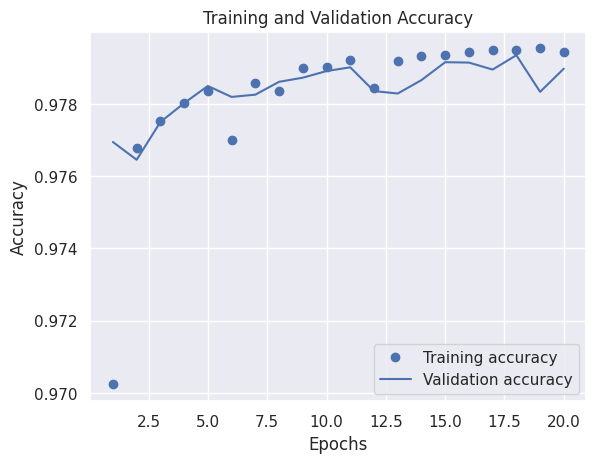

In [ ]:
import matplotlib.pyplot as plt

# Get training history
training_accuracy = gru_history.history['binary_accuracy']
validation_accuracy = gru_history.history['val_binary_accuracy']
epochs = range(1, len(training_accuracy) + 1)

plt.plot(epochs, training_accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
predictions = gru_model.predict(GRU_test_padded)

4787/4787 [==============================] - 15s 3ms/step


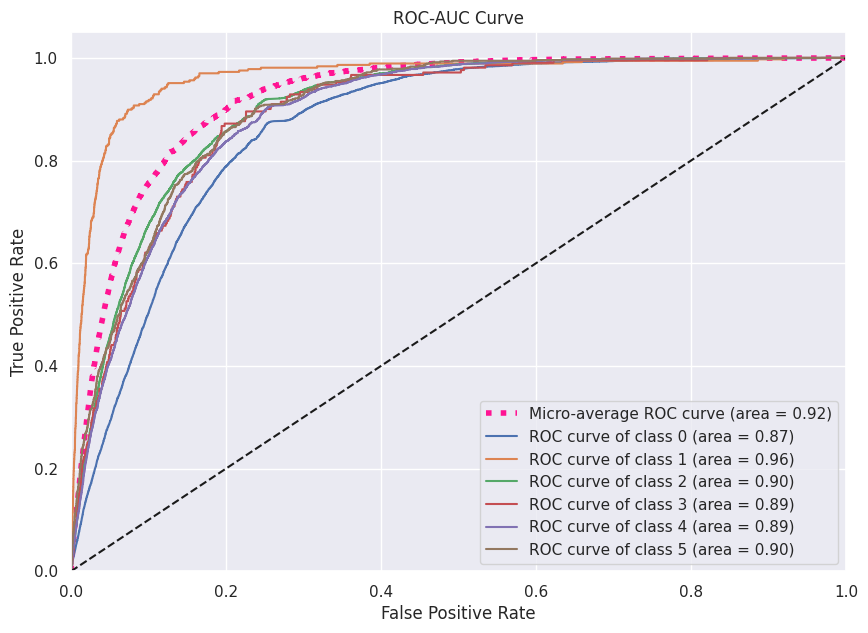

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Convert predictions to binary predictions
threshold = 0.5  # Adjust this threshold based on your problem
binary_predictions = (predictions > threshold).astype(int)

# Convert test_labels to numpy array if it's not already
test_labels_np = np.array(test_labels)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_np[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(test_labels_np.ravel(), predictions.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr_micro, tpr_micro, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_micro), color='deeppink', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
def preprocess_text(sentence):
    """
    Preprocesses a single sentence by cleaning, stemming, lemmatizing, tokenizing, and padding it.

    Parameters:
    sentence (str): The input sentence to be preprocessed.

    Returns:
    numpy.ndarray: The preprocessed and padded sequence.
    """
    # Clean the input sentence
    cleaned_sent = clean_text(sentence)

    # Stem the cleaned sentence
    stemmed_sent = stem_tokens(cleaned_sent)

    # Lemmatize the stemmed sentence
    lemmatized_sent = lemmatize_tokens(stemmed_sent)

    # Convert the lemmatized sentence to a sequence of integers
    sequence = GRU_tokenizer.texts_to_sequences([lemmatized_sent])

    # Pad the sequence to ensure uniform length
    padded_sequence = pad_sequences(sequence, maxlen=max_length)

    return padded_sequence


In [ ]:
def classify_toxicity(sentence, model, tokenizer, max_length, threshold=0.5):
    """
    Classifies the toxicity of a given sentence using a trained model.

    Parameters:
    sentence (str): The input sentence to be classified.
    model (keras.Model): The trained model for toxicity classification.
    tokenizer (keras.preprocessing.text.Tokenizer): The Tokenizer object used for tokenization.
    max_length (int): The maximum length of sequences after padding.
    threshold (float): The threshold value for binary classification (default is 0.5).

    Returns:
    int: 1 if the sentence is classified as toxic, 0 if it is classified as non-toxic.
    """
    # Preprocess the sentence
    cleaned_sentence = preprocess_text(sentence)

    # Tokenize and pad the preprocessed sentence
    sequence = GRU_tokenizer.texts_to_sequences([cleaned_sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_length)

    # Apply threshold for binary classification
    prediction = model.predict(np.array([padded_sequence])) > threshold

    return prediction  # Return 1 if toxic, 0 if non-toxic


In [ ]:
comment_toxic = 'i hate you, kill yourself, screw you'
preprocessed_toxic_comment = preprocess_text(comment_toxic)
probabilities = gru_model.predict(preprocessed_toxic_comment)

threshold = 0.5
binary_prediction = (probabilities > threshold).astype(int)
prediction_text = ""
for i, col in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    prediction_text += f"{col:<{20}}: {binary_prediction[0][i]:<{5}}\n"
print(prediction_text)

1/1 [==============================] - 0s 34ms/step
toxic               : 1    
severe_toxic        : 0    
obscene             : 1    
threat              : 0    
insult              : 1    
identity_hate       : 0    



In [ ]:
comment_non = "you're amazing"
preprocessed_non_comment = preprocess_text(comment_non)
probabilities = gru_model.predict(preprocessed_non_comment)


threshold = 0.5
binary_prediction = (probabilities > threshold).astype(int)
prediction_text = ""
for i, col in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    prediction_text += f"{col:<{20}}: {binary_prediction[0][i]:<{5}}\n"
print(prediction_text)

1/1 [==============================] - 0s 49ms/step
toxic               : 0    
severe_toxic        : 0    
obscene             : 0    
threat              : 0    
insult              : 0    
identity_hate       : 0    



**Conclusion of GRU**

The GRU model achieved a test accuracy of 94%.<br>
The ROC-AUC curves and scores for each class provide further insight into the model's performance across different classes.<br>
Analyzing these metrics can help in identifying potential areas for improvement and further tuning the model.